In [48]:
# Let's start off by importing the relevant libraries
import pandas as pd
import numpy as np
import math
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Loading data

In [49]:
# Import raw data
def import_data():
    url = "C:\\Users\\ivonnics\\Documents\\JOSE LUIS\\Cursos Cursera\\Machine Learning\\PROPHET\\simple-example-master\\data\\Power-Networks-LCL-June2015(withAcornGps)v2_1.csv"
    raw_data_df = pd.read_csv(url, header=0) # creates a Pandas data frame for input value
    return raw_data_df

In [50]:
raw_data_df = import_data()
raw_data_df.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0,ACORN-A,Affluent
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0,ACORN-A,Affluent
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0,ACORN-A,Affluent
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0,ACORN-A,Affluent
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0,ACORN-A,Affluent


In [51]:
#display all data replace result by desired raw_data
result=raw_data_df
result['date']=pd.to_datetime(result['DateTime'])
data=result.loc[:, ['KWH/hh (per half hour) ']]
data = data.set_index(result.date)
data['KWH/hh (per half hour) '] = pd.to_numeric(data['KWH/hh (per half hour) '],downcast='float',errors='coerce')

In [52]:
data.head()

,KWH/hh (per half hour)
date,
2012-10-12 00:30:00,0.0
2012-10-12 01:00:00,0.0
2012-10-12 01:30:00,0.0
2012-10-12 02:00:00,0.0
2012-10-12 02:30:00,0.0


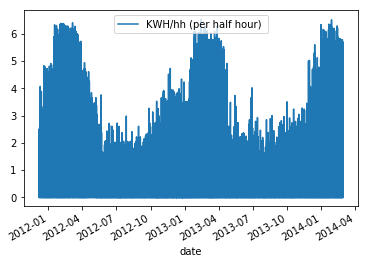

In [53]:
data.plot()

In [54]:
data.dropna().describe()

,KWH/hh (per half hour)
count,999971.000000
mean,0.239580
std,0.387533
min,0.000000
25%,0.060000
50%,0.129000
75%,0.255000
max,6.528000


## Resampling

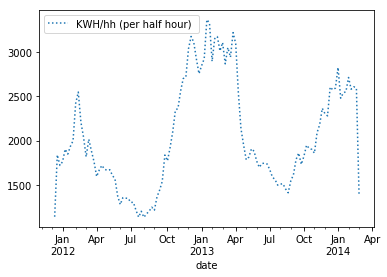

In [55]:
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'])

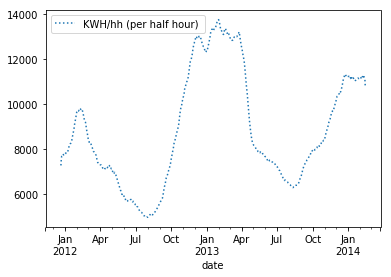

In [56]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])

In [57]:
day= data.resample(rule='H').sum()
day.head()

,KWH/hh (per half hour)
date,
2011-12-06 13:00:00,0.239
2011-12-06 14:00:00,0.271
2011-12-06 15:00:00,0.280
2011-12-06 16:00:00,0.281
2011-12-06 17:00:00,0.256


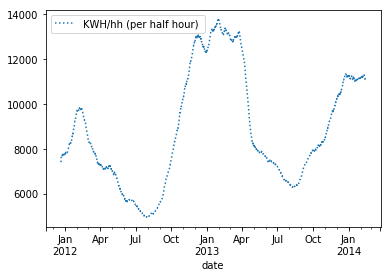

In [58]:
day.rolling(30*24, center=True).sum().plot(style=[':', '--', '-'])

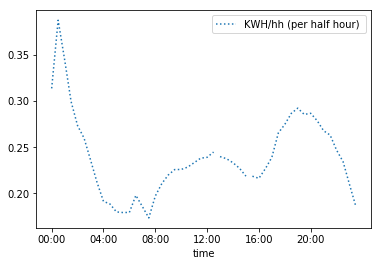

In [59]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

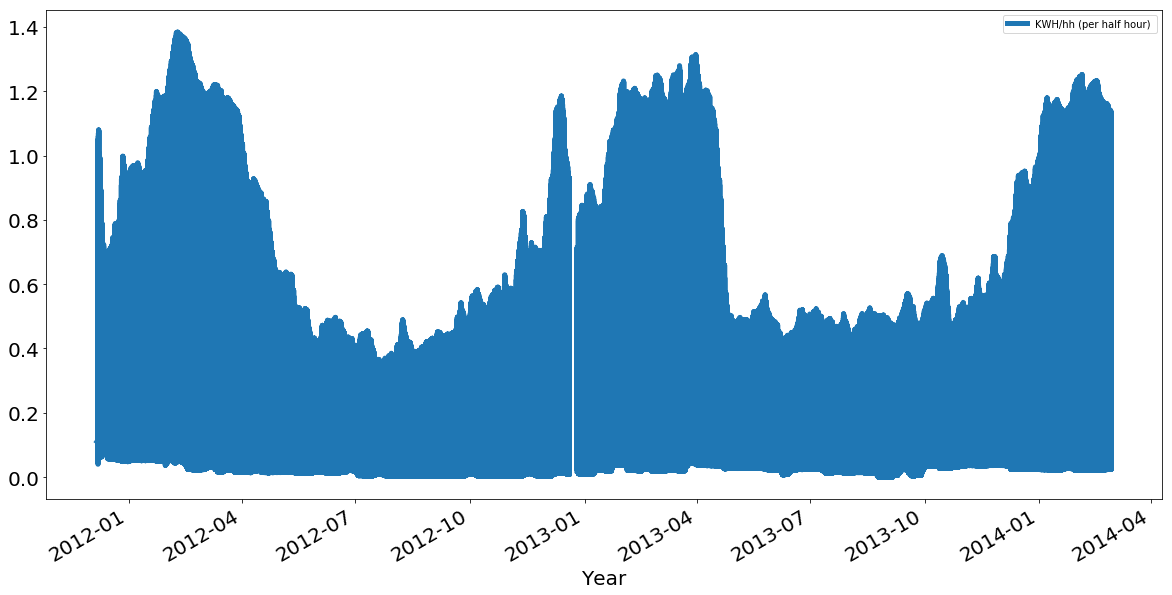

In [60]:
data.rolling(360).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

## Additional explorations

In [61]:
df = raw_data_df.loc[:,['date', 'KWH/hh (per half hour) ']]
df['KWH/hh (per half hour) ']=pd.to_numeric(df['KWH/hh (per half hour) '],errors='coerce')
df = df.groupby(['date']).sum().reset_index()
df.head()

,date,KWH/hh (per half hour)
0,2011-12-06 13:00:00,0.105
1,2011-12-06 13:30:00,0.134
2,2011-12-06 14:00:00,0.141
3,2011-12-06 14:30:00,0.130
4,2011-12-06 15:00:00,0.149


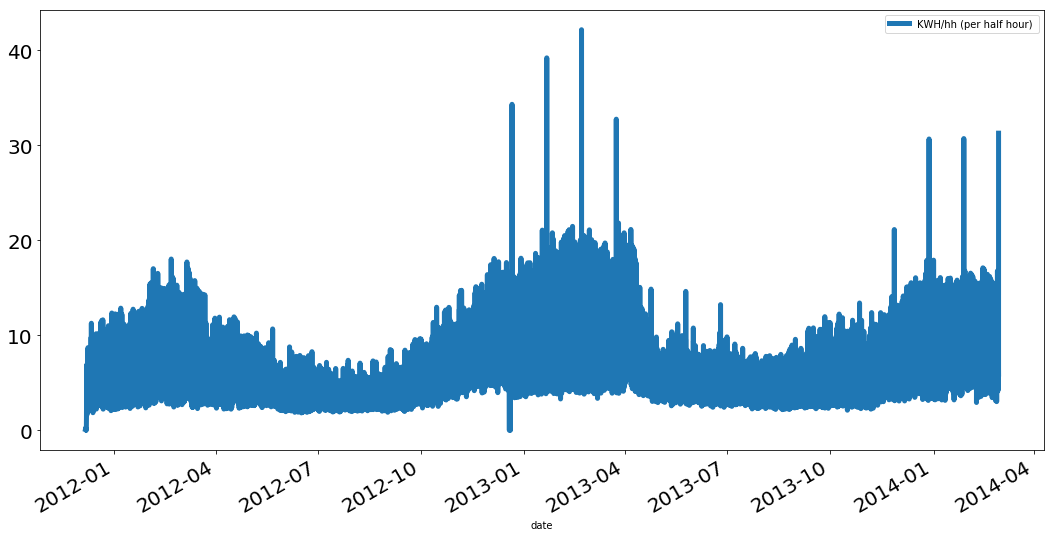

In [62]:
df.plot.line(x = 'date', y = 'KWH/hh (per half hour) ',  figsize=(18,9), linewidth=5, fontsize=20)
plt.show()

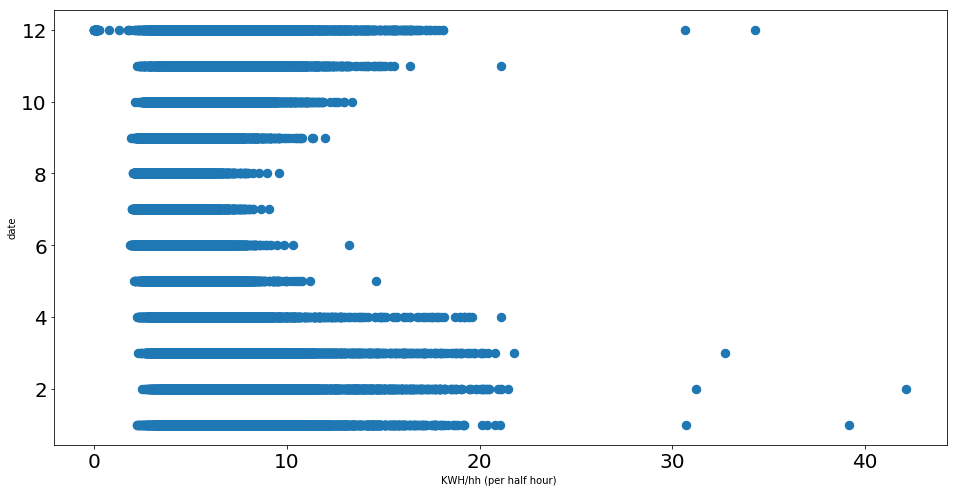

In [63]:
mon = df['date']
temp= pd.DatetimeIndex(mon)
month = pd.Series(temp.month)
to_be_plotted  = df.drop(['date'], axis = 1)
to_be_plotted = to_be_plotted.join(month)
to_be_plotted.plot.scatter(x = 'KWH/hh (per half hour) ', y = 'date', figsize=(16,8), linewidth=5, fontsize=20)
plt.show()

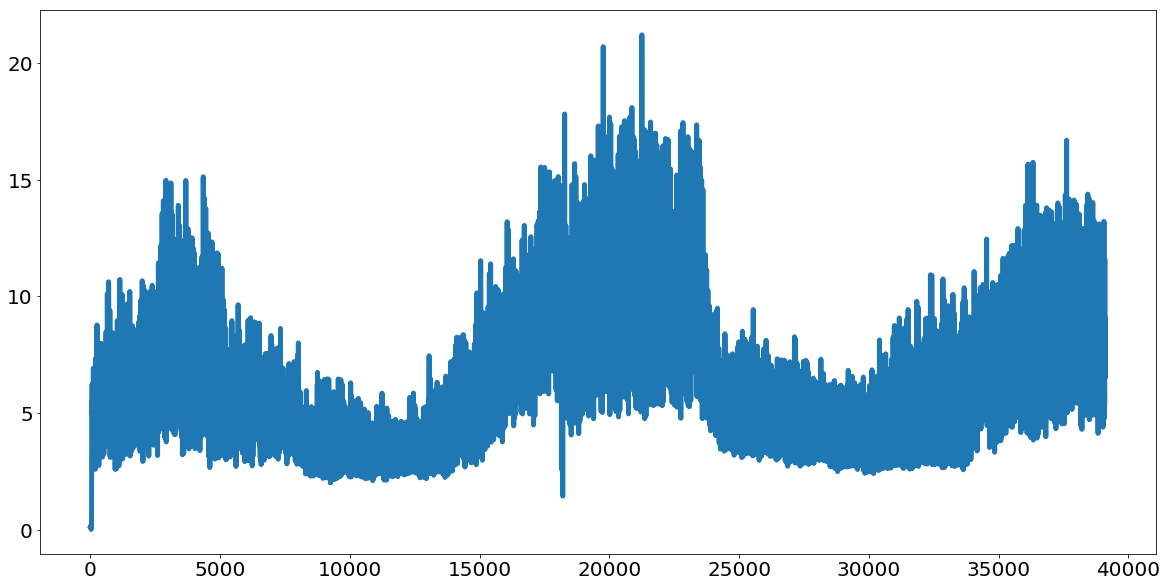

In [64]:
# for trend analysis
df['KWH/hh (per half hour) '].rolling(5).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

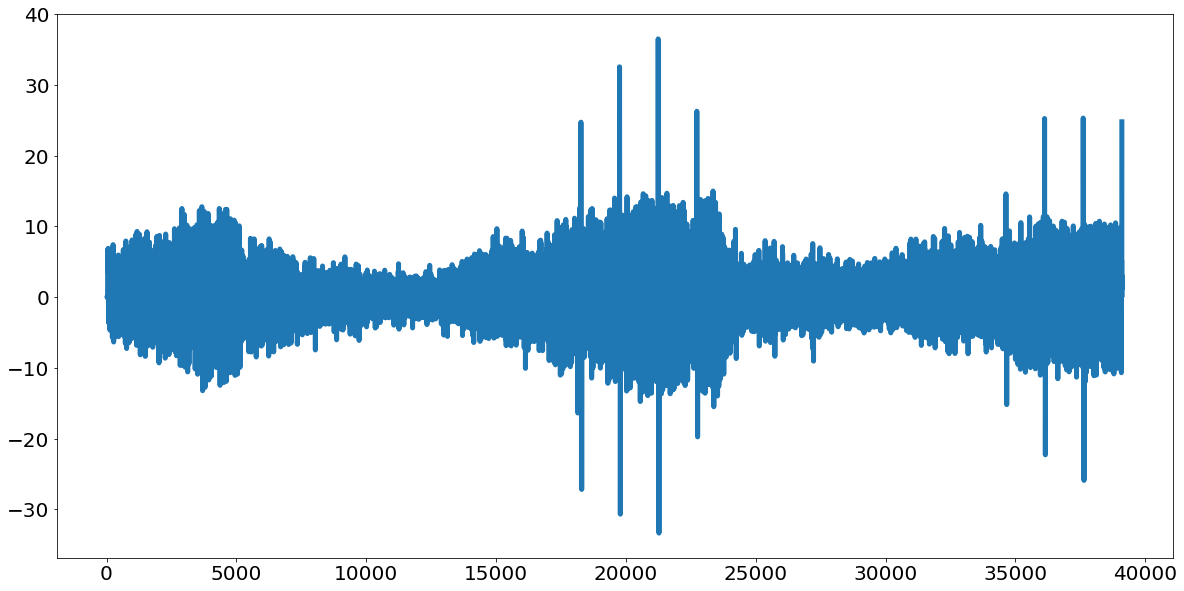

In [65]:
# For seasonal variations
df['KWH/hh (per half hour) '].diff(periods=30).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

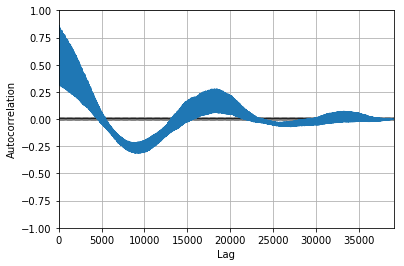

In [66]:
pd.plotting.autocorrelation_plot(df['KWH/hh (per half hour) '])
plt.show()

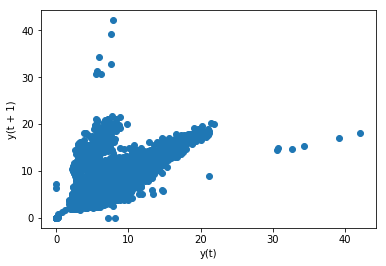

In [67]:
pd.plotting.lag_plot(df['KWH/hh (per half hour) '])
plt.show()

# LSTM prediction

In [68]:
mydata=daily.loc[:, ['KWH/hh (per half hour) ']]
mydata = mydata.set_index(daily.index)
mydata.head()

,KWH/hh (per half hour)
date,
2011-12-06,2.947000
2011-12-07,143.160004
2011-12-08,248.373993
2011-12-09,216.326996
2011-12-10,246.167999


In [69]:
#Use MinMaxScaler to normalize 'KWH/hh (per half hour) ' to range from 0 to 1
from sklearn.preprocessing import MinMaxScaler
values = mydata['KWH/hh (per half hour) '].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [70]:
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

652 164


In [71]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [72]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
np.save('trainY', trainY)
np.save('testY', testY)

650
162


In [73]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX)
print("-------------------------------------------------------------------")
print(testX)
np.save('trainX', trainX)
np.save('testX', testX)

[[[0.         0.2755959 ]]

 [[0.2755959  0.48239943]]

 [[0.48239943 0.41940942]]

 ...

 [[0.47561634 0.46883124]]

 [[0.46883124 0.5050603 ]]

 [[0.5050603  0.5230981 ]]]
-------------------------------------------------------------------
[[[0.52139205 0.54054636]]

 [[0.54054636 0.49141937]]

 [[0.49141937 0.5129697 ]]

 [[0.5129697  0.5110532 ]]

 [[0.5110532  0.49089065]]

 [[0.49089065 0.4756065 ]]

 [[0.4756065  0.46952903]]

 [[0.46952903 0.4814481 ]]

 [[0.4814481  0.43635836]]

 [[0.43635836 0.458404  ]]

 [[0.458404   0.5456882 ]]

 [[0.5456882  0.5554216 ]]

 [[0.5554216  0.49819854]]

 [[0.49819854 0.49495146]]

 [[0.49495146 0.49983385]]

 [[0.49983385 0.491897  ]]

 [[0.491897   0.49809244]]

 [[0.49809244 0.50258565]]

 [[0.50258565 0.54635453]]

 [[0.54635453 0.5093078 ]]

 [[0.5093078  0.5092764 ]]

 [[0.5092764  0.6045742 ]]

 [[0.6045742  0.5837413 ]]

 [[0.5837413  0.5043291 ]]

 [[0.5043291  0.5296218 ]]

 [[0.5296218  0.57763237]]

 [[0.57763237 0.5395773 ]]

 [

In [74]:
trainX = np.load('trainX.npy')
testX = np.load('testX.npy')
trainY = np.load('trainY.npy')
testY = np.load('testY.npy')
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

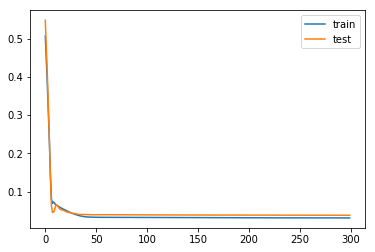

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

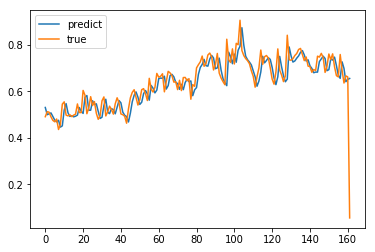

In [76]:
yhat = model.predict(testX)
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()

In [77]:
from math import sqrt
from sklearn.metrics import mean_squared_error
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 33.747


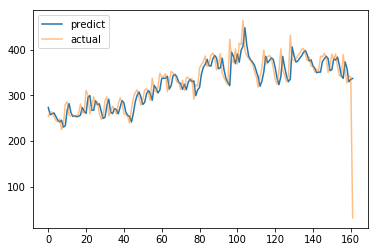

In [78]:
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()

# Clustering

In [79]:
raw_data_df['date']=pd.to_datetime(raw_data_df['DateTime'])
raw_data_df['dy']=raw_data_df['date'].dt.dayofyear
raw_data_df['heure']=raw_data_df['date'].dt.time
data_2014=raw_data_df.loc[:, ['heure','dy','KWH/hh (per half hour) ']]
temp=raw_data_df.loc[:, ['dy','KWH/hh (per half hour) ']]
data_2014['KWH/hh (per half hour) ']=pd.to_numeric(data_2014['KWH/hh (per half hour) '],errors='coerce')
temp=temp.set_index(data_2014.heure)
temp=data_2014.pivot_table(index=['heure'],columns=['dy'] ,values=['KWH/hh (per half hour) '],fill_value=0)

temp.head()

KWH/hh (per half hour)                                           \
dy                           1         2         3         4         5     
heure                                                                      
00:00:00                0.492473  0.445541  0.449703  0.488811  0.473973   
00:30:00                0.609878  0.547743  0.525905  0.566122  0.537689   
01:00:00                0.559878  0.483986  0.485324  0.500986  0.527378   
01:30:00                0.512122  0.463473  0.436176  0.467122  0.444838   
02:00:00                0.469351  0.417446  0.410689  0.417730  0.419770   

                                                              ...     \
dy             6         7         8         9         10     ...      
heure                                                         ...      
00:00:00  0.494973  0.491338  0.484108  0.444351  0.467162    ...      
00:30:00  0.555230  0.595162  0.547932  0.495135  0.552703    ...      
01:00:00  0.506297  0.506068  0.478986  0.455203  0.466811    ...      
01:30:00  0.465446  0.462365  0.436986  0.413189  0.422459    ...      
02:00:00  0.420824  0.439135  0.390000  0.366122  0.376824    ...      

                                                                      \
dy             357       358       359       360       361       362   
heure                                                                  
00:00:00  0.474811  0.470635  0.457297  0.452757  0.483365  0.494410   
00:30:00  0.511486  0.523919  0.515486  0.527676  0.525459  0.544297   
01:00:00  0.453905  0.457041  0.448243  0.458527  0.475865  0.507568   
01:30:00  0.395081  0.402324  0.377351  0.406770  0.396365  0.460270   
02:00:00  0.361635  0.335446  0.367397  0.353527  0.362378  0.434108   

                                                  
dy             363       364       365       366  
heure                                             
00:00:00  0.487432  0.528743  0.512959  0.558931  
00:30:00  0.535014  0.580122  0.590946  0.520103  
01:00:00  0.490905  0.519500  0.514527  0.487517  
01:30:00  0.442270  0.477405  0.469324  0.419655  
02:00:00  0.408649  0.438689  0.430446  0.434759  

[5 rows x 366 columns]

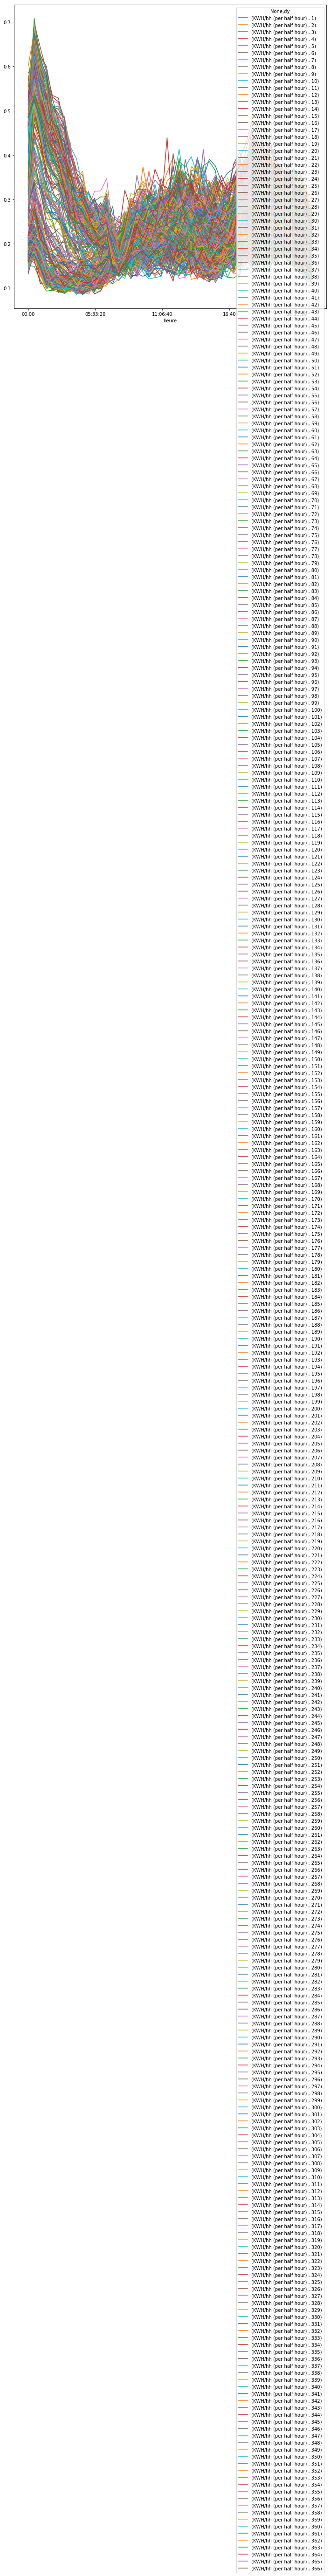

In [80]:
temp.plot(figsize=(12, 12))

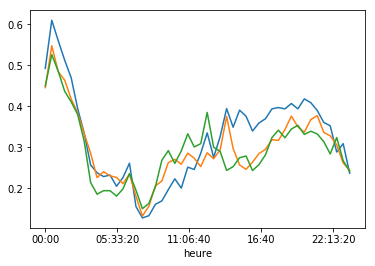

In [81]:
temp.iloc[:,0].plot(x=temp.index.get_level_values)
temp.iloc[:,1].plot(x=temp.index.get_level_values)
temp.iloc[:,2].plot(x=temp.index.get_level_values)

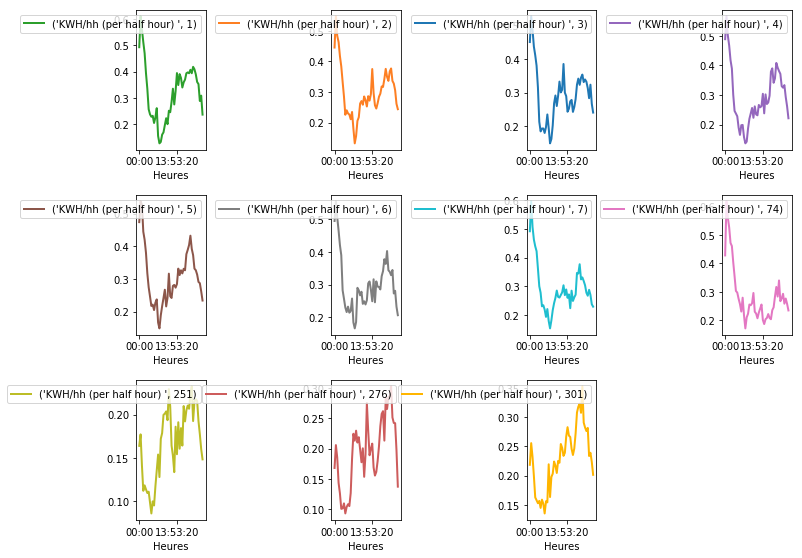

In [82]:
plt.figure(figsize=(11,10))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27',
          '#CD5C5C',"#FFB500"]

for i, r in enumerate([0,1,2,3, 4,5,6,73, 250, 275 ,300],1):
     
    plt.subplot(4,4,i)
    plt.plot(temp.iloc[:,r],  color=colors[i], linewidth=2)
    plt.xlabel('Heures')
    plt.legend(loc='upper right')
    plt.tight_layout()

In [83]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(temp.iloc[:,0:365], 'ward')

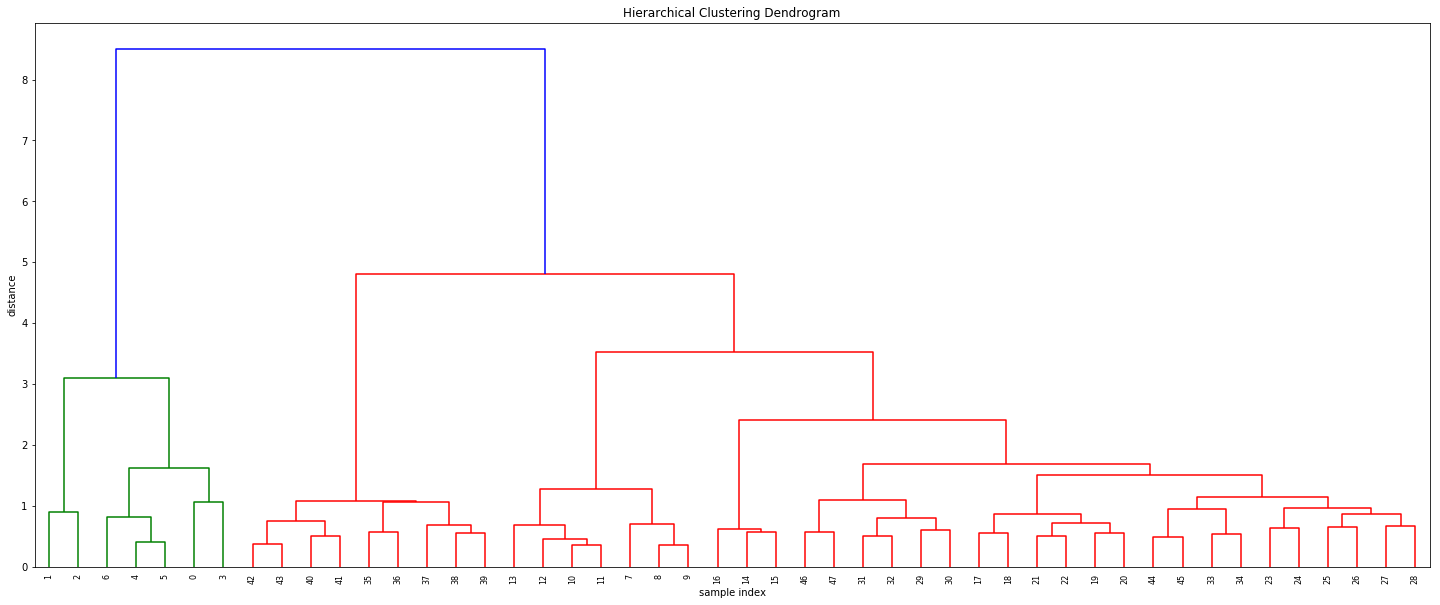

In [84]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

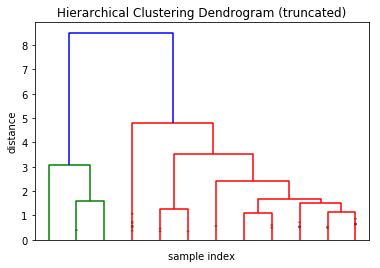

In [85]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

# Modeling with Prophet

In [86]:
df2=daily
df2.reset_index(inplace=True)
# Prophet requires columns ds (Date) and y (value)
df2 = df2.rename(columns={'date': 'ds', 'KWH/hh (per half hour) ': 'y'})

df2.head()
df2.to_csv('exampleprophet.csv')

### A partir de aquí comienzas a correr en el Environment de Prophet...

In [1]:
import pandas as pd
df2 = pd.read_csv('exampleprophet.csv')
df2

,Unnamed: 0,ds,y
0,0,2011-12-06,2.94700
1,1,2011-12-07,143.16000
2,2,2011-12-08,248.37400
3,3,2011-12-09,216.32700
4,4,2011-12-10,246.16800
5,5,2011-12-11,277.64900
6,6,2011-12-12,266.04200
7,7,2011-12-13,230.62900
8,8,2011-12-14,268.98400
9,9,2011-12-15,277.57100


### Aquí tienes que cambiar de Environment para correr esta parte en Prophet...

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import fbprophet
# Make the prophet model and fit on the data
df2_prophet = fbprophet.Prophet(changepoint_prior_scale=0.10)
df2_prophet.fit(df2)
warnings.resetwarnings()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [3]:
# Make a future dataframe for 2 month
df2_forecast = df2_prophet.make_future_dataframe(periods=30*2 , freq='D')
# Make predictions
df2_forecast = df2_prophet.predict(df2_forecast)

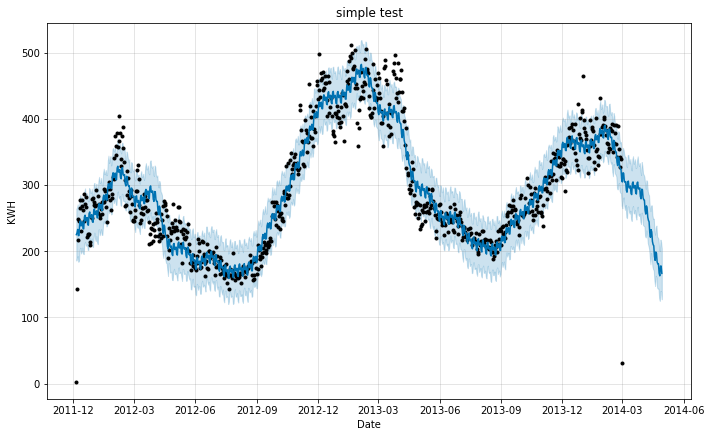

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
df2_prophet.plot(df2_forecast, xlabel = 'Date', ylabel = 'KWH')
plt.title('simple test');

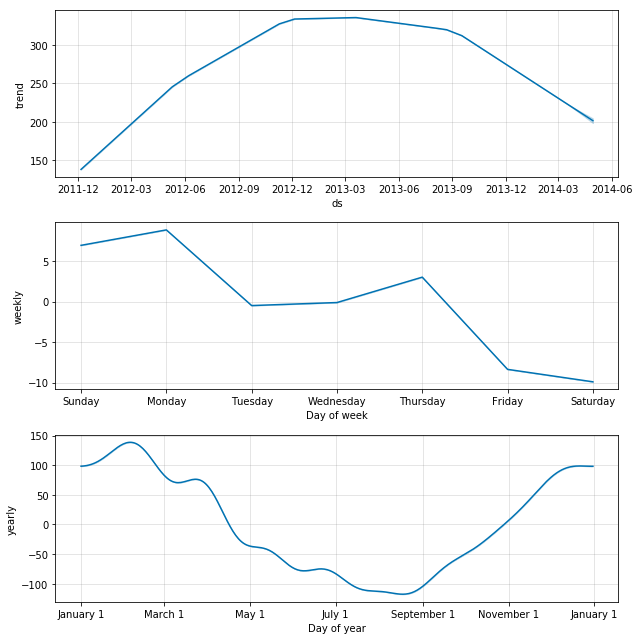

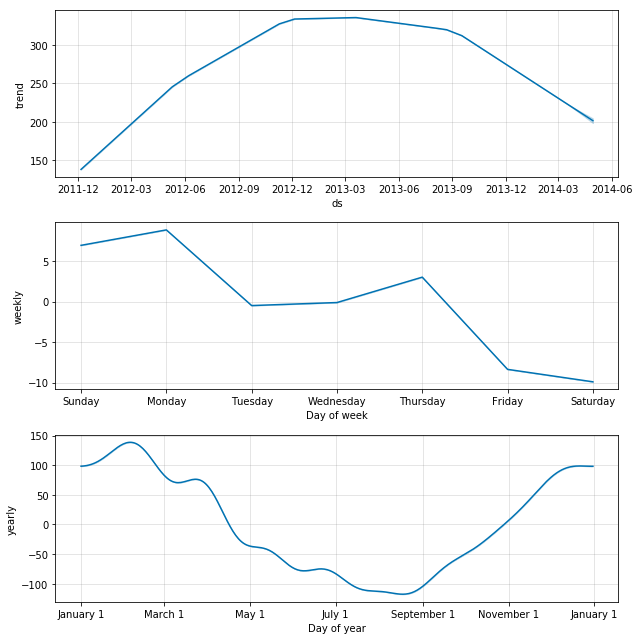

In [5]:
# Plot the trends and patterns
df2_prophet.plot_components(df2_forecast)